Mounted at /content/drive
         Date Symbol Series  Prev Close    Open    High     Low    Last  \
0  2004-08-25    TCS     EQ      850.00  1198.7  1198.7  979.00  985.00   
1  2004-08-26    TCS     EQ      987.95   992.0   997.0  975.30  976.85   
2  2004-08-27    TCS     EQ      979.00   982.4   982.4  958.55  961.20   
3  2004-08-30    TCS     EQ      962.65   969.9   990.0  965.00  986.40   
4  2004-08-31    TCS     EQ      986.75   986.5   990.0  976.00  987.80   

    Close     VWAP    Volume      Turnover  Trades  Deliverable Volume  \
0  987.95  1008.32  17116372  1.725876e+15     NaN             5206360   
1  979.00   985.65   5055400  4.982865e+14     NaN             1294899   
2  962.65   969.94   3830750  3.715586e+14     NaN              976527   
3  986.75   982.65   3058151  3.005106e+14     NaN              701664   
4  988.10   982.18   2649332  2.602133e+14     NaN              695234   

   %Deliverble  
0       0.3042  
1       0.2561  
2       0.2549  
3       0.

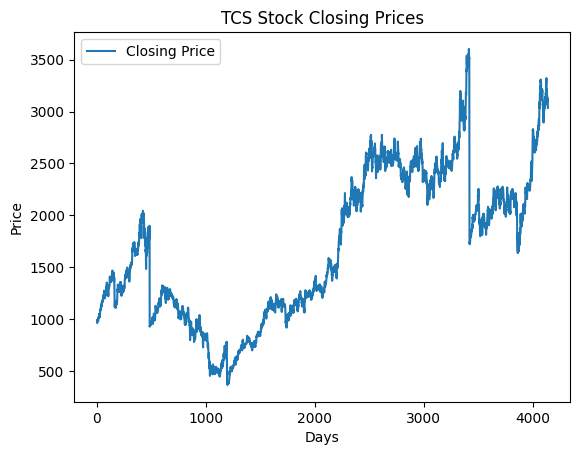

In [10]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


data = pd.read_csv('/content/drive/My Drive/stocks_dataset/TCS.csv')
print(data.head())
data = data[['Date','Close']]
plt.plot(data["Close"], label="Closing Price")
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("TCS Stock Closing Prices")
plt.legend()
plt.show()

              Close  Close t-1  Close t-2  Close t-3  Close t-4  Close t-5
Date                                                                      
2004-09-01   987.90     988.10     986.75     962.65     979.00     987.95
2004-09-02   993.65     987.90     988.10     986.75     962.65     979.00
2004-09-03   997.85     993.65     987.90     988.10     986.75     962.65
2004-09-06   994.85     997.85     993.65     987.90     988.10     986.75
2004-09-07   995.60     994.85     997.85     993.65     987.90     988.10
...             ...        ...        ...        ...        ...        ...
2021-04-26  3100.80    3109.50    3118.80    3144.55    3161.80    3195.15
2021-04-27  3132.00    3100.80    3109.50    3118.80    3144.55    3161.80
2021-04-28  3124.10    3132.00    3100.80    3109.50    3118.80    3144.55
2021-04-29  3115.25    3124.10    3132.00    3100.80    3109.50    3118.80
2021-04-30  3035.65    3115.25    3124.10    3132.00    3100.80    3109.50

[4134 rows x 6 columns]


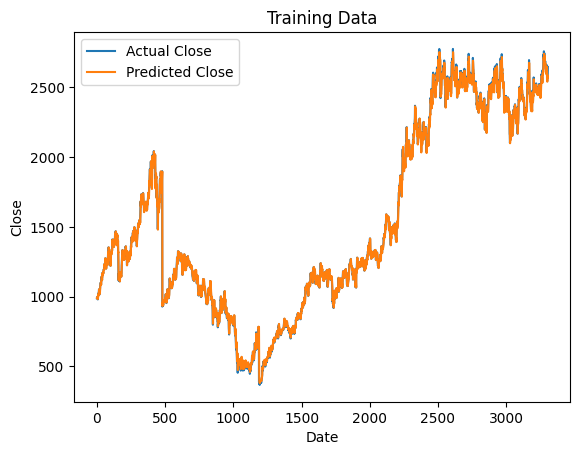

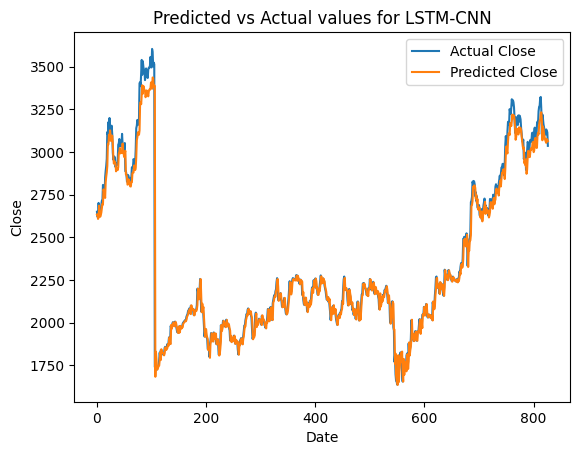

 Train Mean Squared Error [0,1]: 0.02031273
 Train Mean Squared Error [0,1]: 0.048141547


In [11]:
# Method : CNN-LSTM

# preparing LSTM series for the past 5 days
prev_days = 5
lstm_data = data.copy()
lstm_data.set_index('Date',inplace=True)
for i in range(1, prev_days+1):
    lstm_data[f'Close t-{i}'] = lstm_data['Close'].shift(i)
lstm_data.dropna(inplace=True)
print(lstm_data)
lstm_data = lstm_data.to_numpy()
adjust = MinMaxScaler(feature_range=(-1,1))
lstm_data = adjust.fit_transform(lstm_data)

close_price = np.array(lstm_data[:,0])
prev_5_prices = np.array(lstm_data[:,1:])
prev_5_prices = dc(np.flip(prev_5_prices, axis=1))

split = int(len(close_price)*0.8)
x_train = prev_5_prices[:split]
y_train = close_price[:split]
x_test = prev_5_prices[split:]
y_test = close_price[split:]

x_train = x_train.reshape((-1,5,1)) # makes number of features as 1 -> each individual price is treated as a single feature at each time step
x_test = x_test.reshape((-1,5,1))
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

class TimeSeriesDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

train_dataset = TimeSeriesDataset(x_train,y_train)
test_dataset = TimeSeriesDataset(x_test,y_test)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = 1
hidden_size = 5
stacked_layers = 1
learning_rate = 0.01

model = nn.Sequential(
    nn.LSTM(input_size, hidden_size,stacked_layers, batch_first=True),
    nn.Linear(hidden_size, 1))

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_one_epoch(model, train_loader, loss_function, optimizer):
    model.train()
    running_loss = 0.0

    for batch_index, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        # forward pass to lstm layer using input
        lstm_output, _ = model[0](x_batch)
        output = model[1](lstm_output[:, -1, :])
        loss = loss_function(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    #print(f'Training Loss: {avg_loss}')

def validate_one_epoch(model, test_loader, loss_function):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_index, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            lstm_output, _ = model[0](x_batch) # getting the output tensor from the lstm layer
            output = model[1](lstm_output[:, -1, :])  # passing the last time step's output to the linear layer
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    avg_loss=running_loss/len(test_loader)
    #print(f'Validation Loss: {avg_loss:.4f}')

for epoch in range(20):
  #print(f"Epoch {epoch+1}:")
  train_one_epoch(model, train_loader, loss_function, optimizer)
  validate_one_epoch(model, test_loader, loss_function)

# doing forward pass through the LSTM layer and extracting the last time step's output, then passing the last time step's output to the linear layer
def make_predictions(input):
  lstm_output, _ = model[0](input.to(device))
  last_output = lstm_output[:, -1, :]
  predicted = model[1](last_output)
  return predicted.to('cpu').detach().numpy()

train_predictions = make_predictions(x_train)
test_predictions = make_predictions(x_test)

numeric_data = data.drop(columns=['Date'])
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(numeric_data)

y_train_original_scale = scaler.inverse_transform(y_train.reshape(-1, 1))
predicted_original_scale = scaler.inverse_transform(train_predictions.reshape(-1, 1))
y_test_org_scale = scaler.inverse_transform(y_test.reshape(-1, 1))
test_pred_org_scaler = scaler.inverse_transform(test_predictions.reshape(-1, 1))

plt.title('Training Data')
plt.plot( y_train_original_scale, label='Actual Close')
plt.plot( predicted_original_scale, label='Predicted Close')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

plt.title('Predicted vs Actual values for LSTM-CNN')
plt.plot( y_test_org_scale, label='Actual Close')
plt.plot( test_pred_org_scaler, label='Predicted Close')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

rms = np.sqrt(metrics.mean_squared_error(y_train,train_predictions))
print(" Train Mean Squared Error [0,1]:",rms)
rms = np.sqrt(metrics.mean_squared_error(y_test,test_predictions))
print(" Train Mean Squared Error [0,1]:",rms)

Train Accuracy: 0.6079429735234216
Test Accuracy: 0.5345528455284553


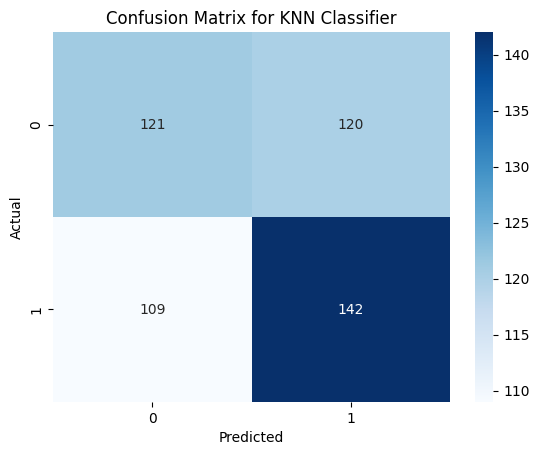

Test Mean Squared Error [0,1]: 0.37046321803107596


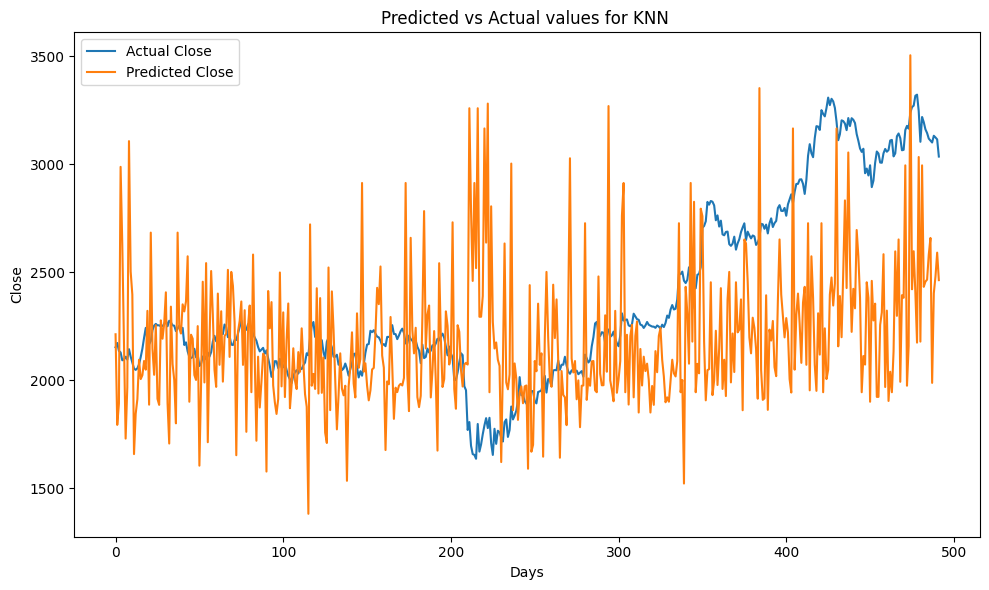

In [12]:
# Method : KNN
# Classification Problem: Buy(+1) or sell(-1) the stock

data = pd.read_csv('/content/drive/My Drive/stocks_dataset/TCS.csv')
data["Open - Close"] = data["Open"] - data["Close"]
data["High - Low"] = data["High"] - data["Low"]
data = data.dropna()
X = data[["Open - Close", "High - Low","Volume","Turnover"]]
X.head()
Y = np.where(data["Close"].shift(-1) > data["Close"], 1, -1) #if the next day's closing price is greater than today's closing price, then 1, else -1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2) # 20 percent of the data is used for testing and 80 percent for training

# split_index = int(len(X) * 0.8)
# X_train, X_test = X[:split_index], X[split_index:]
# Y_train, Y_test = Y[:split_index], Y[split_index:]

params = {"n_neighbors": np.arange(1, 25)} #we want to find k which is a hyperparameter, so we use GridSearchCV to find the best k
knn = neighbors.KNeighborsClassifier()
model = GridSearchCV(knn, params, cv = 5)
model.fit(X_train, Y_train)
accuracy_for_train = metrics.accuracy_score(Y_train, model.predict(X_train))
accuracy_for_test = metrics.accuracy_score(Y_test, model.predict(X_test))

print('Train Accuracy:', accuracy_for_train)
print('Test Accuracy:', accuracy_for_test)
predictions = model.predict(X_test)
actual_and_predicted_data = pd.DataFrame({"Actual": Y_test, "Predicted": predictions})

cm = confusion_matrix(Y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for KNN Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#X_train_regression, X_test_regression, Y_train_regression, Y_test_regression = train_test_split(X, data["Close"], test_size = 0.2, random_state = 30)

scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_Y = MinMaxScaler(feature_range=(-1, 1))
X = scaler_X.fit_transform(X)
data["Close"] = scaler_Y.fit_transform(data[['Close']])

split_index = int(len(X) * 0.8)
X_train_regression = X[:split_index]
X_test_regression = X[split_index:]
Y_train_regression = data["Close"][:split_index]
Y_test_regression = data["Close"][split_index:]

params = {"n_neighbors": np.arange(1, 25)}
knn = neighbors.KNeighborsRegressor()
model_regression = GridSearchCV(knn, params, cv = 5)
model_regression.fit(X_train_regression, Y_train_regression)
predictions = model_regression.predict(X_test_regression)

rms = np.sqrt(metrics.mean_squared_error(Y_test_regression, predictions))
print("Test Mean Squared Error [0,1]:",rms)

valids = pd.DataFrame({"Actual": Y_test_regression, "Predicted": predictions})
actual_close = scaler_Y.inverse_transform(valids["Actual"].values.reshape(-1, 1)).flatten()
predicted_close = scaler_Y.inverse_transform(valids["Predicted"].values.reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 6))
plt.plot(actual_close, label='Actual Close')
plt.plot(predicted_close, label='Predicted Close')
plt.title('Predicted vs Actual values for KNN ')
plt.xlabel('Days')
plt.ylabel('Close')
plt.legend()
plt.tight_layout()
plt.show()

Train Accuracy: 1.0
Test Accuracy: 0.5021341463414636


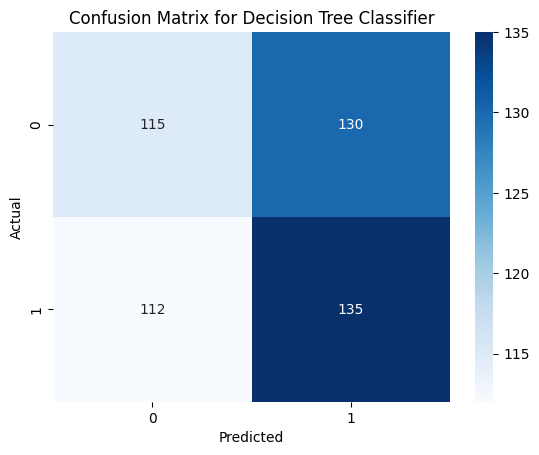

Mean Squared Error: 1.967479674796748


In [15]:
# Method : Decision Trees Classifier
data = pd.read_csv('/content/drive/My Drive/stocks_dataset/TCS.csv')
data["Open - Close"] = data["Open"] - data["Close"]
data["High - Low"] = data["High"] - data["Low"]
data = data.dropna()
X = data[["Open - Close","High - Low","Volume","Turnover"]]
X.head()
Y = np.where(data["Close"].shift(-1) > data["Close"], 1, -1) #if the next day's closing price is greater than today's closing price, then 1, else -1

x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size = 0.2) # 20 percent of the data is used for testing and 80 percent for training

train_lst = []
test_lst = []
for i in range(100):
    clf = DecisionTreeClassifier()
    clf.fit(x_train, y_train)
    train_accuracy = clf.score(x_train, y_train)
    test_accuracy = clf.score(x_test, y_test)
    train_lst.append(train_accuracy)
    test_lst.append(test_accuracy)

train_array = np.array(train_lst)
test_array = np.array(test_lst)

print("Train Accuracy:", np.mean(train_array))
print("Test Accuracy:", np.mean(test_array))

predictions = clf.predict(x_test)
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Decision Tree Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Mean Squared Error [0,1]: 0.00010230344741430204


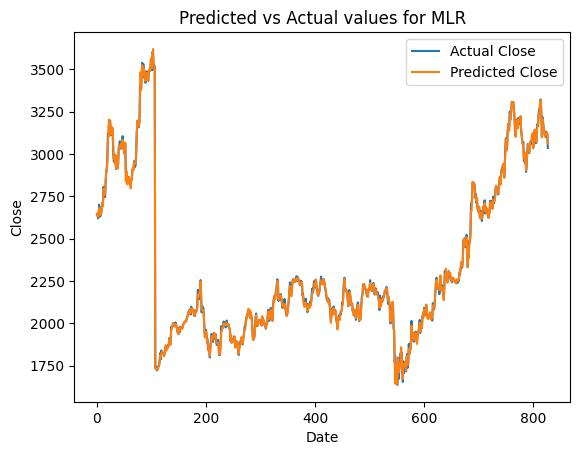

In [14]:
# Method : Multi-Linear Regression

data = pd.read_csv('/content/drive/My Drive/stocks_dataset/TCS.csv')
X = data[["Open","High","Low","Volume","Turnover"]]
Y = data[["Close"]]

def centralise(X):
  X = X.to_numpy()
  adjust = MinMaxScaler(feature_range=(-1,1))
  X = adjust.fit_transform(X)
  return X, adjust

X,X_scaler = centralise(X)
Y,Y_scaler = centralise(Y)

split = int(len(X)*0.8)
x_train = X[:split]
y_train = Y[:split]
x_test = X[split:]
y_test = Y[split:]

model = LinearRegression()
model.fit(x_train, y_train)
predictions_train = model.predict(x_train)
predictions_test = model.predict(x_test)

mse = mean_squared_error(y_test, predictions_test)
print("Mean Squared Error [0,1]:", mse)

numeric_data = data[["Close"]]
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(numeric_data)

y_test_org_scale = scaler.inverse_transform(y_test.reshape(-1, 1))
test_pred_org_scaler = scaler.inverse_transform(predictions_test.reshape(-1, 1))

# y_train_original_scale = scaler.inverse_transform(y_train.reshape(-1, 1))
# predicted_original_scale = scaler.inverse_transform(predictions_train.reshape(-1, 1))
# plt.title('Training Data')
# plt.plot( y_train_original_scale, label='Actual Close')
# plt.plot( predicted_original_scale, label='Predicted Close')
# plt.xlabel('Date')
# plt.ylabel('Close')
# plt.legend()
# plt.show()

plt.title('Predicted vs Actual values for MLR')
plt.plot( y_test_org_scale, label='Actual Close')
plt.plot( test_pred_org_scaler, label='Predicted Close')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()